In [1]:
import pathlib
import pickle

from astropy.io import fits
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from gala.units import galactic
from scipy.stats import binned_statistic, binned_statistic_2d
import torusimaging as oti
from torusimaging_helpers.make_sim_data import make_mgfe
from torusimaging_helpers.plot import plot_bdata

In [2]:
# See: scripts/jason-sims/aligner.py
tbl = at.Table(fits.getdata("../data/Jason-r2-B2-disk.fits"))

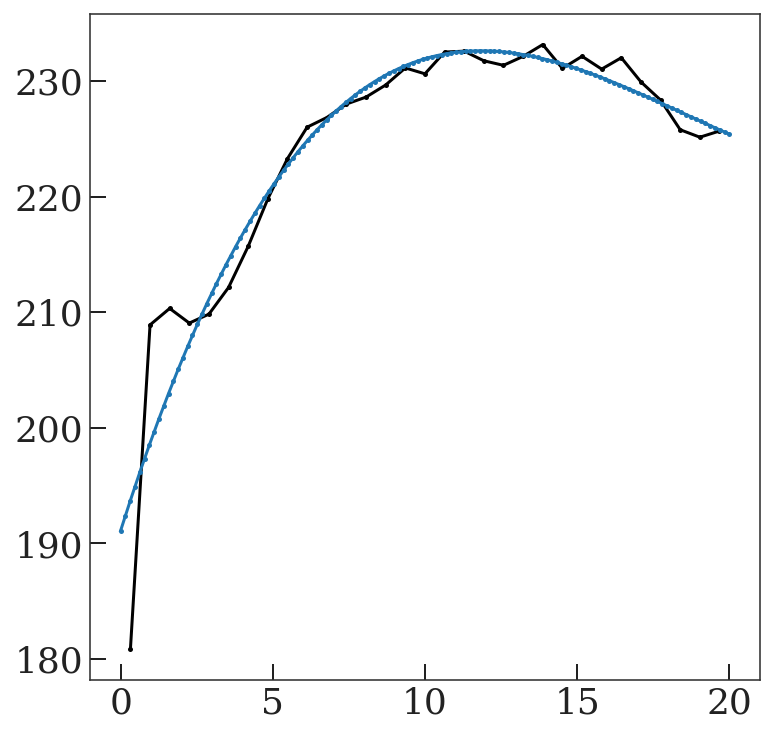

In [3]:
# Select low vertical and radial action particles to get rotation curve:
J_mask = (tbl["J"][:, 0] < np.nanpercentile(tbl["J"][:, 0], 15)) & (
    tbl["J"][:, 2] < np.nanpercentile(tbl["J"][:, 2], 15)
)
vc_stat = binned_statistic(
    tbl["R"][J_mask], tbl["v_phi"][J_mask], bins=np.linspace(0, 20, 32)
)
xc = 0.5 * (vc_stat.bin_edges[:-1] + vc_stat.bin_edges[1:])
vc_poly = np.polynomial.Polynomial.fit(xc, vc_stat.statistic, deg=3)

vc = vc_poly(tbl["R"])
tbl["Rg"] = tbl["J"][:, 1] / vc

plt.plot(xc, vc_stat.statistic)

_grid = np.linspace(0, 20, 128)
plt.plot(_grid, vc_poly(_grid))

In [4]:
xy_stat = binned_statistic_2d(
    tbl["xyz"][:, 0],
    tbl["xyz"][:, 1],
    tbl["vxyz"][:, 2],
    bins=np.linspace(-20, 20, 128),
)

6.0


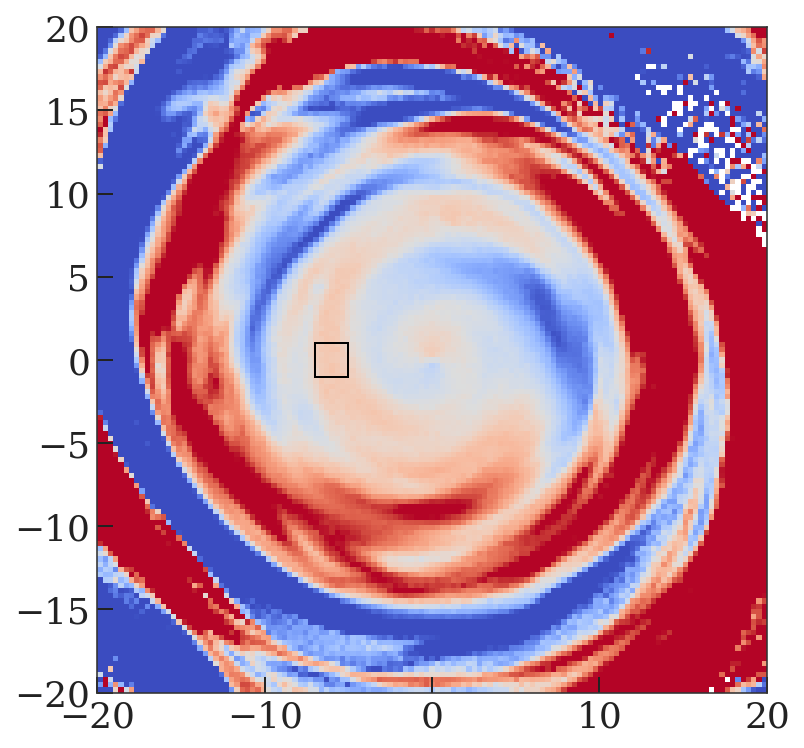

In [5]:
# x0 = -6.5
# y0 = 5
x0 = -6.0
y0 = 0
R0 = np.sqrt(x0**2 + y0**2)
print(R0)

xy_size = 2.0

fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolormesh(
    xy_stat.x_edge,
    xy_stat.y_edge,
    xy_stat.statistic.T,
    cmap="coolwarm",
    vmin=-10,
    vmax=10,
)
rect = mpl.patches.Rectangle(
    (x0 - xy_size / 2, y0 - xy_size / 2),
    xy_size,
    xy_size,
    facecolor="none",
    edgecolor="k",
)
ax.add_patch(rect)

In [6]:
print(vc_poly(R0), R0)  # 228.36 * 7.5 ~= 1712

224.43236152373788 6.0


In [7]:
mask = (
    (np.abs(tbl["R"] - tbl["Rg"]) < xy_size / 2)
    # & (np.abs(tbl["R"] - R0) < 1)
    & (np.abs(tbl["v_R"]) < 20)
    & (np.abs(tbl["xyz"][:, 0] - x0) < xy_size / 2)
    & (np.abs(tbl["xyz"][:, 1] - y0) < xy_size / 2)
)
pdata = at.QTable(tbl[mask])

In [12]:
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    zmax = np.sqrt(2 * pdata["init_J"][:, 2] / pdata["init_Omega"][:, 2]) * u.kpc

rng = np.random.default_rng(123)
pdata["z"] = pdata["xyz"][:, 2] * u.kpc
pdata["v_z"] = pdata["vxyz"][:, 2] * u.km / u.s
pdata["mgfe"], pdata["mgfe_err"] = make_mgfe(zmax, rng=rng, slope=0.12, std=0.01)

In [13]:
max_z = np.round(3 * np.nanpercentile(pdata["z"].to(u.kpc), 90), 1)
max_vz = np.round(3 * np.nanpercentile(pdata["v_z"].to(u.km / u.s), 90), 0)

print(max_z, max_vz)
zvz_bins = {
    "pos": np.linspace(-max_z, max_z, 151),
    "vel": np.linspace(-max_vz, max_vz, 151),
}

1.6 kpc 107.0 km / s


In [14]:
bdata = oti.get_binned_label(
    pdata["z"].astype("f8"),
    pdata["v_z"].astype("f8"),
    label=pdata["mgfe"].astype("f8"),
    label_err=pdata["mgfe_err"].astype("f8"),
    bins=zvz_bins,
    units=galactic,
    s=0.0,
)

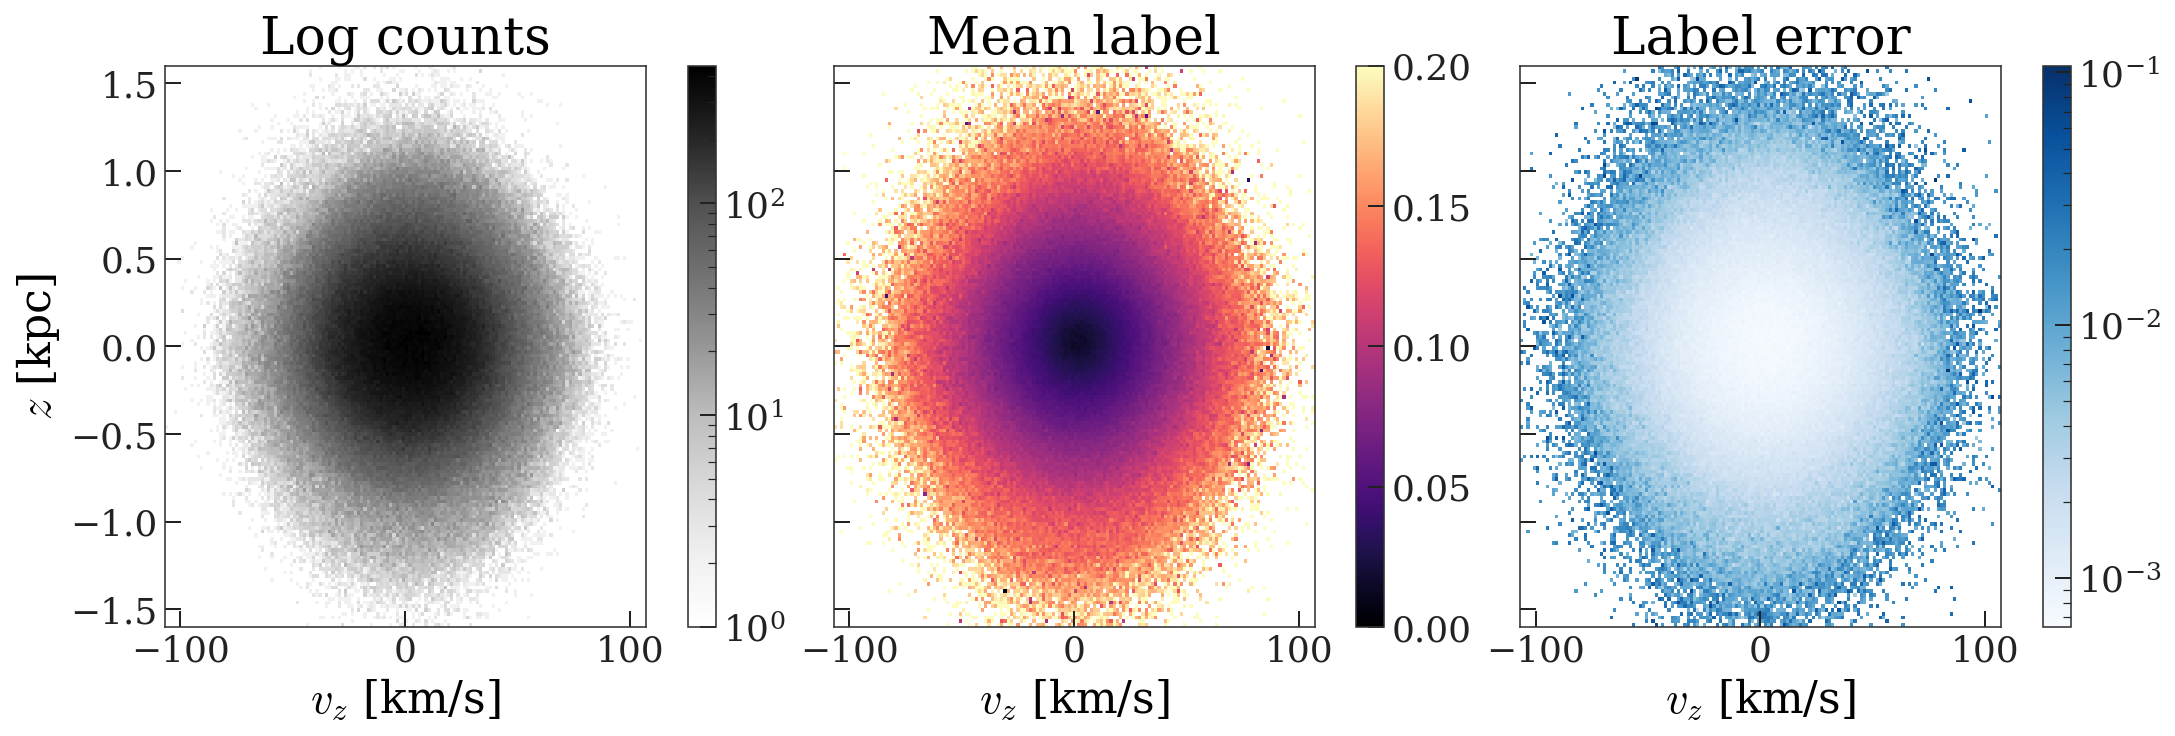

In [15]:
_ = plot_bdata(bdata, label_vlim=(0, 0.2))